In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score
from sklearn import svm
from sklearn import preprocessing
%matplotlib inline

This function will help me to show the result of the prediction models, so we will be able to evaluate it visually.

In [3]:
mape = lambda y_actual, y_predicted: np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100


def display_predicted_prices(predictions, real, prices_last, y_weeks_nr):
    df = pd.DataFrame()
    predictions_price = prices_last + (prices_last * predictions)
    true_price = prices_last + (prices_last * real)
    df['predictions_price'] = predictions_price
    df['true_price'] = true_price
    df['predictions'] = predictions
    df['real'] = real
    df['week_nr'] = y_weeks_nr
    print("MAPE", mape(true_price, predictions_price))
    print("MSE", mean_squared_error(true_price, predictions_price))
    print("Accuracy", accuracy_score(np.sign(real), np.sign(predictions)))
    plt.plot(df['predictions'], label='Predicted')
    plt.plot(df['real'], label='Real')
    plt.legend()
    plt.show()

    plt.plot(df['predictions_price'], label='Predicted price')
    plt.plot(df['true_price'], label='Real price')
    plt.legend()
    plt.show()

Let's load the preprocessed data and filter for Jaén province. After some test, I realized the other provinces have a small amount of data, not good enough for modeling.

In [4]:
oo_df = pd.read_hdf('data/oo_data_region.hdf', 'data')
oo_jaen = oo_df[oo_df['provincia'] == 'JAEN']
oo_jaen['provincia'] = 1

This function will help me to create datasets so it will be more clear.

In [5]:
def create_dataset(test_size, include_columns=None, df=oo_df, test_column='price_perc'):
    train_df = df[:-test_size].reset_index(drop=True)
    test_df = df[-test_size:].reset_index(drop=True)
    y_train = train_df[test_column]
    y_test = test_df[test_column]
    y_last_prices = test_df['price-1w']
    y_prices_perc = test_df['price_perc']
    if include_columns:
        X_train = train_df[include_columns]
        X_test = test_df[include_columns]
    else:
        drop_columns = ['price_perc', 'price', 'increase', 'price_perc_medium']
        if test_column not in drop_columns:
            drop_columns.append(test_column)
        X_train = train_df.drop(columns=drop_columns)
        X_test = test_df.drop(columns=drop_columns)
    return X_train, y_train, X_test, y_test, y_last_prices, test_df['week_nr'], y_prices_perc

This function test some regressors, linear and non-linear ones, and will show the feature importances for the XGBRegressor. That will be useful for testing different dataset configurations.

In [6]:
def test_some_regressors(X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr):
    regresors = [
        linear_model.LassoLarsCV(),
        linear_model.LinearRegression(n_jobs=8),
        RandomForestRegressor(n_jobs=8),
        XGBRegressor(n_jobs=8)
    ]

    for model in regresors:
        print("Model", model)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        display_predicted_prices(predictions, y_test, y_last_prices, y_weeks_nr)

    fi_df = pd.DataFrame(index=X_train.columns)
    fi_df['Feature Importance'] = model.feature_importances_
    fi_df = fi_df.sort_values(by=['Feature Importance'], ascending=False)
    return fi_df

In [7]:
oo_jaen.columns

Index(['price', 'provincia', 'price-1w', 'price-2w', 'price-4w', 'price+3w',
       'price-6w', 'price-8w', 'price-4w_mean', 'price-8w_mean', 'price_perc',
       'price_perc_medium', 'price_perc-2w', 'price_perc-4w', 'price_perc-6w',
       'price_perc-8w', 'tmin', 'tmax', 'tmed', 'prec', 'racha', 'week_nr',
       'prec-4w_sum', 'prec-13w_sum', 'prec-26w_sum', 'prec-52w_sum',
       'tmed-4w_mean', 'prec-4w_sum_perc', 'prec-13w_sum_perc',
       'prec-26w_sum_perc', 'prec-52w_sum_perc', 'tmed-4w_mean_perc',
       'tmin_perc', 'tmax_perc', 'tmed_perc', 'prec_perc', 'freeze_damage',
       'month', 'production_tons-1m_sum', 'production_tons-3m_sum',
       'production_tons-6m_sum', 'production_tons-9m_sum',
       'production_tons-12m_sum', 'production_tons-1m_sum_perc',
       'production_tons-3m_sum_perc', 'production_tons-6m_sum_perc',
       'production_tons-9m_sum_perc', 'production_tons-12m_sum_perc'],
      dtype='object')

Instead of trying to predict the price, I will try to predict the percentage change, so I can recreate the price using the last week prices and percentage change. The percentage change has the benefit it is not influenced by the price inflation and also it is a value that changes between -0.2 and +0.2 the most of prediction models works better with these ranges.

I manually ran the cell below several times trying features configuration and the features that stay seems to be the best working configuration.

Model LassoLarsCV(copy_X=True, cv=None, eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)
MAPE 1.0131397664917248
MSE 0.002138576500765303
Accuracy 0.4423076923076923


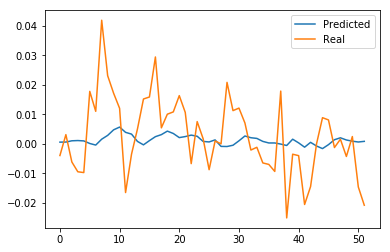

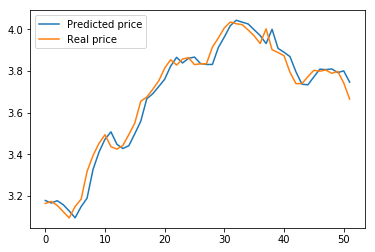

Model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=False)
MAPE 1.0705559074094206
MSE 0.0024145171223425342
Accuracy 0.4807692307692308


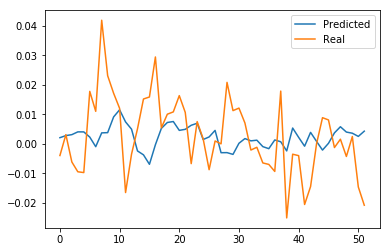

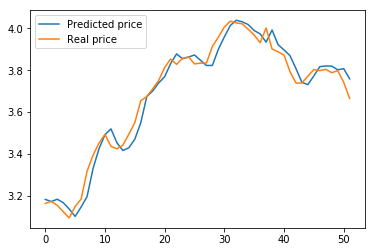

Model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAPE 1.0900711196032566
MSE 0.002683385273683649
Accuracy 0.5384615384615384


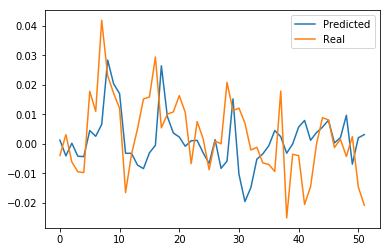

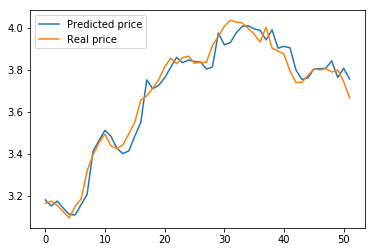

Model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
MAPE 0.998001062326254
MSE 0.0021440184591425115
Accuracy 0.5


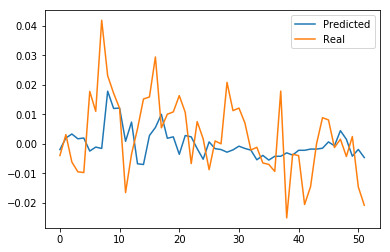

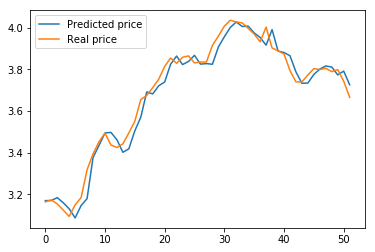

,Feature Importance
price_perc-4w,0.379310
price_perc-2w,0.199234
prec-52w_sum,0.178161
production_tons-12m_sum,0.109195
production_tons-1m_sum,0.090038
freeze_damage,0.044061
provincia,0.000000


In [8]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, include_columns=['provincia', 'price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 'freeze_damage',
                         ], df = oo_jaen)
test_some_regressors(X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr)

I get the errors using the calculated price, using the price percentage prediction, in order to compare with other predictors.

In _J.R. González et al. (Eds.): NICSO 2010, SCI 284, pp. 113–125, 2010_ they compare several methods for the Extra Virgin Olive Oil forecasting. The best result they got was 1.91% MAPE. That result is the best one compared with previous research. These researches were done using just the price data, without including any weather or production data. They were done in different time ranges and for the mean Spanish market.

The best result we have is 0.99% MAPE which is better. 

They do also a 4 week forecasting (mid term). I have the "price-perc-medium" that is a variable that contains the price in 4 weeks, so I will try the mid term forecasting.

Model LassoLarsCV(copy_X=True, cv=None, eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)
MAPE 2.8420664044530826
MSE 0.016362313678638614
Accuracy 0.5192307692307693


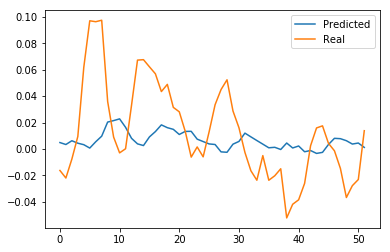

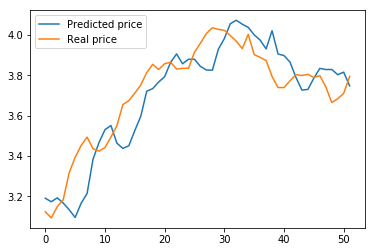

Model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=False)
MAPE 2.961641223970685
MSE 0.017448176853614834
Accuracy 0.5384615384615384


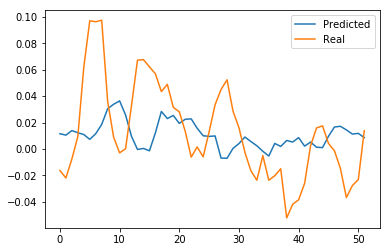

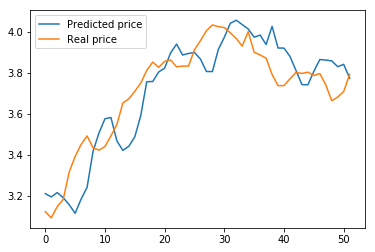

Model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAPE 3.3581535698422456
MSE 0.025917285098871146
Accuracy 0.4807692307692308


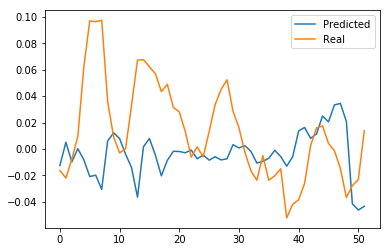

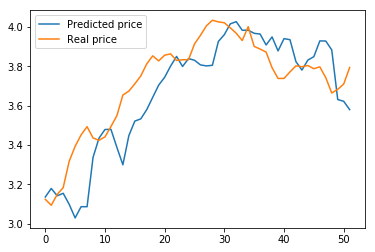

Model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
MAPE 2.793541158945893
MSE 0.018349739984495968
Accuracy 0.6538461538461539


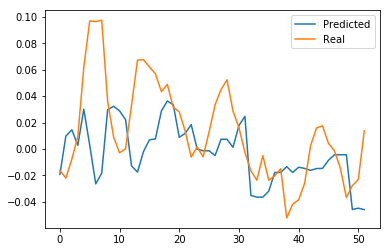

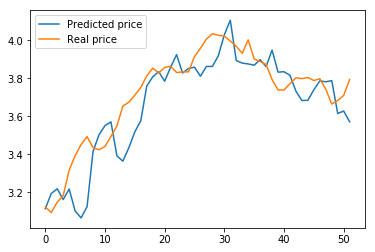

,Feature Importance
price_perc-2w,0.233766
price_perc-4w,0.196429
prec-52w_sum,0.196429
production_tons-12m_sum,0.186688
production_tons-1m_sum,0.173701
freeze_damage,0.012987


In [12]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, include_columns=['price_perc-2w', 'price_perc-4w',
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 'freeze_damage',
                         ], df = oo_jaen, test_column='price_perc_medium')
test_some_regressors(X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr)

The results of the 2010 research were 3.2% MAPE. I got 2.79% MAPE.

I also print the "accuracy" as a classifier (sign matches). For the short term forecasting I had a 50%. For medium term forecasting I got 65%. That is explained because in a medium term forecasting, we don't have small weekly changes.

That means we are doing well but we don't guess if we are going "up" or "down" in an accurate way for a short term forecasting.

What about forecasting the price direction (up or down) instead of trying to forecast the exact price change.

For that, I'll create a new variable named "increase" and also "increase_medium" for trying a medium term classification.

In [9]:
oo_jaen['increase_medium'] = np.sign(oo_jaen['price_perc_medium'])
oo_jaen['increase'] = np.sign(oo_jaen['price_perc'])

This function will help me to visualize the classifier accuracy. Also, I'll print the cummulative return of the classifier.

In [10]:
def score_classifier(predictions, y_test, y_prices_perc, model_name): 
    print('Accuracy:', accuracy_score(y_test, predictions ))
    avgret = y_prices_perc * predictions
    print('Return:', avgret.sum())
    avgret.cumsum().plot(label=model_name, legend=True)
    plt.show()
    
    y_prices_perc.plot(label='Real percentage change', legend=True)
    avgret.plot(label='Return', legend=True)  
    plt.show()

Let's start with the medium term forecasting, XGBClassifier

Accuracy: 0.5384615384615384
Return: 0.0057060619175393


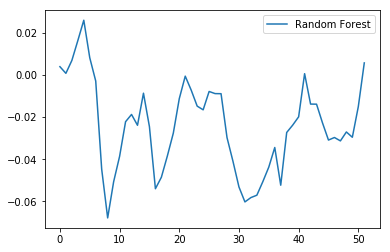

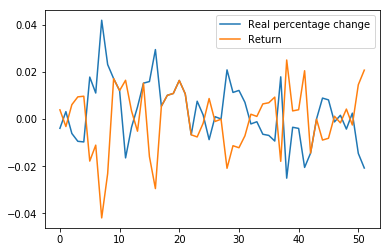

In [15]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, test_column='increase_medium', include_columns=['price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 
                                                 'freeze_damage',
                         ], df=oo_jaen
)

model = XGBClassifier(n_jobs=8)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

score_classifier(predictions, y_test, y_prices_perc, 'Random Forest')

Let's try with mid term forecasting and random forest

Accuracy: 0.6153846153846154
Return: 0.27849181741931367


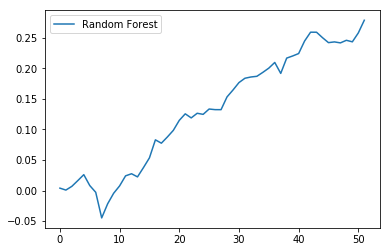

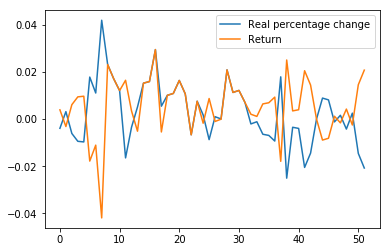

In [16]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, test_column='increase_medium', include_columns=['price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 
                                                 'freeze_damage',
                         ], df=oo_jaen
)

model = RandomForestClassifier(n_jobs=8, random_state=6059)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

score_classifier(predictions, y_test, y_prices_perc, 'Random Forest')

Both options have worse accuracy than the regresor... Let's see with short term

Accuracy: 0.6153846153846154
Return: 0.12190951334472223


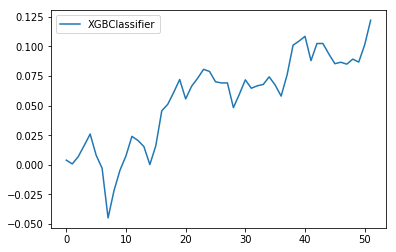

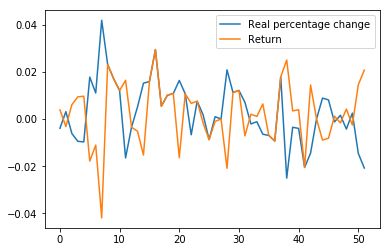

In [18]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, test_column='increase', include_columns=['price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 
                                                 'freeze_damage',
                         ], df=oo_jaen
)
model = XGBClassifier(n_jobs=8)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score_classifier(predictions, y_test, y_prices_perc, 'XGBClassifier')

Here, we have better results than the regressor 61% accuracy and a good cumulative return. Let's try with random forest.

Accuracy: 0.7692307692307693
Return: 0.4087013677359896


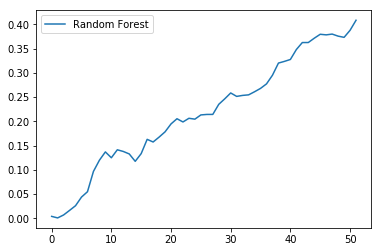

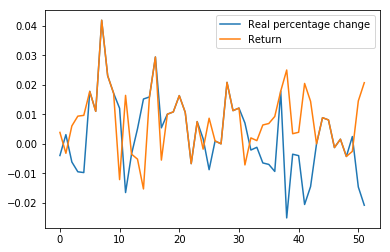

In [19]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, test_column='increase', include_columns=['price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 
                                                 'freeze_damage',
                         ], df=oo_jaen
)
model = RandomForestClassifier(n_jobs=8, random_state=8200)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score_classifier(predictions, y_test, y_prices_perc, 'Random Forest')

This result is really good, a 76% of accuracy with a 40% of annual return (I tested with 52 weeks). The cumulative return grows stable.

As a conclusion, I can say that introducing weather and production data is good for the model, it improves financial models already applied to this prices. Also, not all the weather and production data help, it should be carefully selected.

For a short-term is easier to get the price direction with a classifier than forecast the price percentage change.
For a mid-term is better to predict the price than the percentage change.